# 라이브러리

In [38]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from collections import defaultdict

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# 데이터

In [39]:
# real-instance 3
data = np.array([
    [0, 20870, 430000],
    [1, 41740, 430000],
    [2, 62610, 430000],
    [3, 83480, 430000],
    [4, 104350, 430000],
    [5, 125220, 430000],
    [6, 20870, 438500],
    [7, 41740, 438500],
    [8, 62610, 438500],
    [9, 83480, 438500],
    [10, 104350, 438500],
    [11, 125220, 438500],
    [12, 20870, 447000],
    [13, 41740, 447000],
    [14, 62610, 447000],
    [15, 83480, 447000],
    [16, 104350, 447000],
    [17, 125220, 447000],
    [18, 20870, 455500],
    [19, 41740, 455500],
    [20, 62610, 455500],
    [21, 83480, 455500],
    [22, 104350, 455500],
    [23, 125220, 455500],
    [24, 20870, 464000],
    [25, 41740, 464000],
    [26, 62610, 464000],
    [27, 83480, 464000],
    [28, 104350, 464000],
    [29, 125220, 464000],
    [30, 20870, 472500],
    [31, 41740, 472500],
    [32, 62610, 472500],
    [33, 83480, 472500],
    [34, 104350, 472500],
    [35, 125220, 472500],
    [36, 20870, 481000],
    [37, 41740, 481000],
    [38, 62610, 481000],
    [39, 83480, 481000],
    [40, 104350, 481000],
    [41, 125220, 481000],
    [42, 41740, 489500],
    [43, 62610, 489500],
    [44, 83480, 489500],
    [45, 104350, 489500],
    [46, 125220, 489500],
    [47, 20870, 498000],
    [48, 41740, 498000],
    [49, 62610, 498000],
    [50, 83480, 498000],
    [51, 104350, 498000],
    [52, 125220, 498000],
    [53, 20870, 506500],
    [54, 41740, 506500],
    [55, 62610, 506500],
    [56, 83480, 506500],
    [57, 104350, 506500],
    [58, 125220, 506500],
    [59, 20870, 515000],
    [60, 41740, 515000],
    [61, 62610, 515000],
    [62, 83480, 515000],
    [63, 104350, 515000],
    [64, 125220, 515000],
    [65, 20870, 523500],
    [66, 41740, 523500],
    [67, 62610, 523500],
    [68, 83480, 523500],
    [69, 104350, 523500],
    [70, 125220, 523500],
    [71, 20870, 532000],
    [72, 41740, 532000],
    [73, 62610, 532000],
    [74, 83480, 532000],
    [75, 104350, 532000],
    [76, 125220, 532000],
    [77, 20870, 540500],
    [78, 41740, 540500],
    [79, 62610, 540500],
    [80, 83480, 540500],
    [81, 104350, 540500],
    [82, 125220, 540500],
    [83, 20870, 549000],
    [84, 41740, 549000],
    [85, 62610, 549000],
    [86, 83480, 549000],
    [87, 104350, 549000],
    [88, 125220, 549000],
    [89, 20870, 557500],
    [90, 41740, 557500],
    [91, 62610, 557500],
    [92, 83480, 557500],
    [93, 104350, 557500],
    [94, 125220, 557500],
    [95, 20870, 566000],
    [96, 41740, 566000],
    [97, 62610, 566000],
    [98, 83480, 566000],
    [99, 20870, 574500],
    [100, 41740, 574500],
    [101, 62610, 574500],
    [102, 83480, 574500],
    [103, 20870, 583000],
    [104, 41740, 583000],
    [105, 62610, 583000],
    [106, 20870, 591500],
    [107, 41740, 591500],
])
inverter = np.array([20870 , 489500 ])
data = np.array(data)

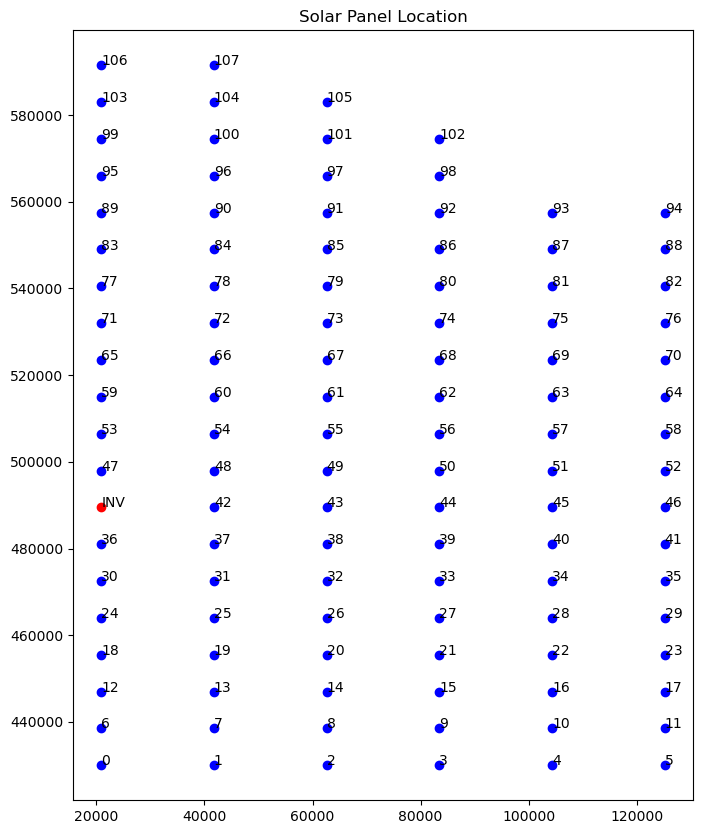

In [48]:
plt.figure(figsize=(8, 10))
plt.scatter(x=data[:, 1], y=data[:, 2], color='blue')
plt.scatter(x=inverter[0], y=inverter[1], color='red')
for i in range(len(data)):
    plt.text(x=data[i][1], y=data[i][2], s = i)

plt.text(x=inverter[0], y=inverter[1], s='INV')
plt.title('Solar Panel Location')
plt.show()

# KMeans 클러스터링 (Capacitated)
- Type 1 Combiner Box: This type can receive input from a maximum of 6 PVAs.
- Type 2 Combiner Box: This type can receive input from a maximum of 8 PVAs

In [41]:
print(f'Number of PVA : {len(data)}')
print(f'Number of clusters if Combiner Box is Type 1 : {len(data)/6}')
print(f'Number of clusters if Combiner Box is Type 2 : {len(data)/8}')

Number of PVA : 108
Number of clusters if Combiner Box is Type 1 : 18.0
Number of clusters if Combiner Box is Type 2 : 13.5


In [42]:
# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Capacitated K-Means 알고리즘 (demands = 1)
def capacitated_kmeans(data, k, max_capacity, max_iters=100):
    n = len(data)
    demands = np.ones(n)  # 모든 포인트의 demands를 1로 설정
    
    # Step 1: 초기 중심점 선택 (무작위로 k개의 중심점 선택)
    np.random.seed(42)  # 무작위 선택을 위해 시드 고정 (재현 가능성)
    centroids = data[np.random.choice(n, k, replace=False)]

    # 클러스터 할당을 위한 초기화
    clusters = [-1] * n  # 각 데이터 포인트의 클러스터 할당 (-1은 미할당 상태)
    cluster_demands = np.zeros(k)  # 각 클러스터의 총 수요 (즉, 포인트 개수)

    for iteration in range(max_iters):
        # 클러스터 할당을 초기화
        new_clusters = [-1] * n
        cluster_demands = np.zeros(k)
        
        # Step 2: 각 포인트를 가장 가까운 클러스터에 할당 (용량 제한 고려)
        for i, point in enumerate(data):
            priority_list = []
            for j in range(k):
                if cluster_demands[j] + demands[i] <= max_capacity:  # 용량 제한 체크
                    # 거리 계산
                    distance = euclidean_distance(point, centroids[j])
                    priority_list.append((distance, j))
            
            # 가장 가까운 클러스터에 할당
            if priority_list:
                best_distance, best_cluster = min(priority_list)
                new_clusters[i] = best_cluster
                cluster_demands[best_cluster] += demands[i]

        # Step 3: 새로운 중심점 계산
        new_centroids = np.zeros((k, data.shape[1]))
        for j in range(k):
            points_in_cluster = [data[i] for i in range(n) if new_clusters[i] == j]
            if points_in_cluster:
                new_centroids[j] = np.mean(points_in_cluster, axis=0)

        # 할당이 변경되지 않으면 종료
        if new_clusters == clusters:
            break
        clusters = new_clusters
        centroids = new_centroids

    return clusters, centroids

In [43]:
c_data = data[:, 1:]
k = 14
max_capacity = 8
clusters, centroids = capacitated_kmeans(c_data, k, max_capacity)

print("클러스터 할당:", clusters)
print("최종 중심점:", centroids)

클러스터 할당: [0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 3, 3, 5, 5, 9, 9, 3, 3, 5, 5, 9, 9, 3, 3, 5, 5, 9, 9, 12, 5, 5, 7, 9, 12, 12, 12, 7, 7, 7, 12, 12, 12, 7, 7, 10, 11, 12, 13, 13, 7, 10, 11, 11, 13, 13, 10, 10, 11, 11, 13, 13, 10, 10, 11, 11, 13, 13, 8, 10, 11, 4, 6, 8, 8, 10, 4, 4, 6, 8, 8, 8, 4, 4, 6, 8, 4, 6, 6, 8, 4, 6, 6, 4, 6]
최종 중심점: [[ 31305.         442750.        ]
 [ 73045.         442750.        ]
 [114785.         442750.        ]
 [ 31305.         472500.        ]
 [ 28696.25       568125.        ]
 [ 73045.         476750.        ]
 [ 54783.75       572375.        ]
 [101368.57142857 501642.85714286]
 [ 96523.75       556437.5       ]
 [116275.71428571 474928.57142857]
 [120002.5        527750.        ]
 [ 28696.25       532000.        ]
 [ 41740.         502250.        ]
 [ 73045.         527750.        ]]


C:\Users\daftg\AppData\Local\Temp\ipykernel_2756\3428993684.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.sum((p1 - p2) ** 2))


# 시각화

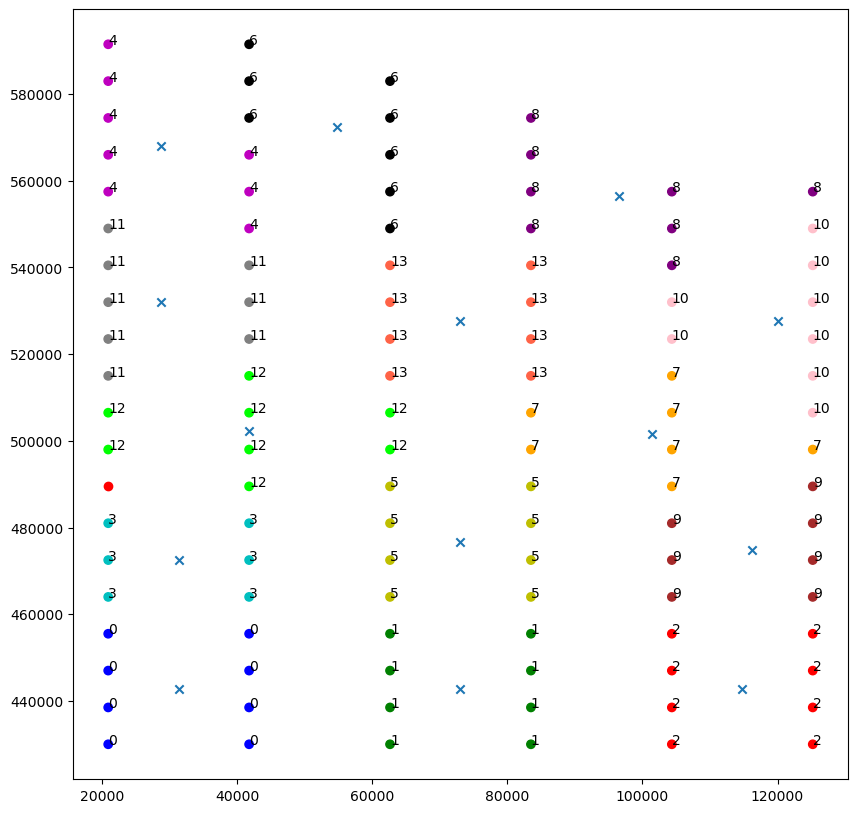

In [44]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500', '#800080', '#A52A2A', '#FFC0CB', '#808080', '#00FF00', '#FF6347']
point_colors = [colors[label % len(colors)] for label in clusters]


plt.figure(figsize=(10, 10))
plt.scatter(x=data[:, 1], y=data[:, 2], c=point_colors)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker='x')
plt.scatter(x=inverter[0], y=inverter[1], color='red')
for i in range(len(data)):
    plt.text(x=data[i][1], y=data[i][2], s=clusters[i])

plt.show()

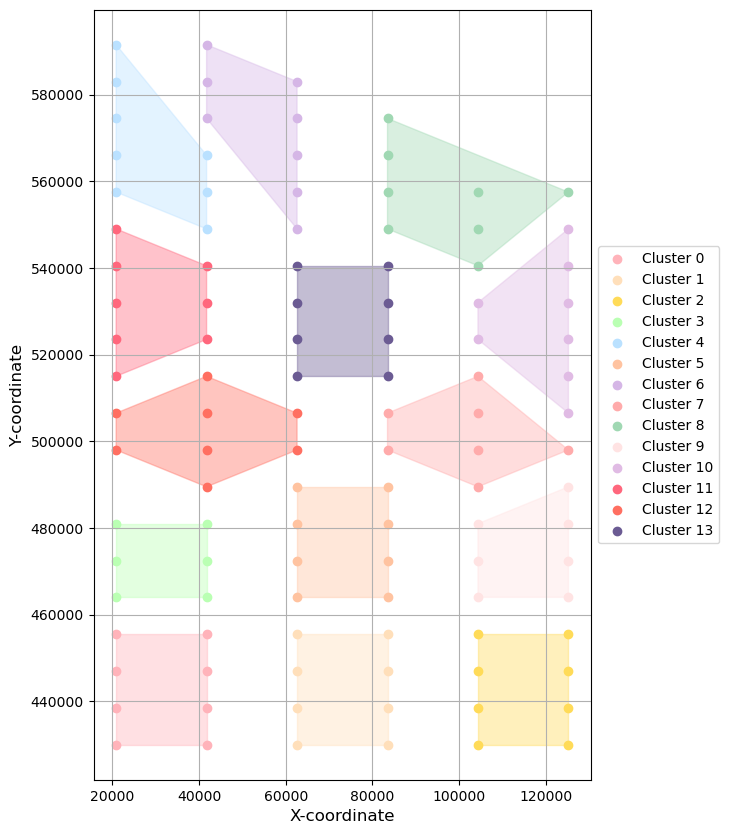

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# 노드 위치 교환 함수 (두 노드의 위치만 교환)
def swap_node_positions(data, idx1, idx2):
    data[idx1], data[idx2] = data[idx2].copy(), data[idx1].copy()  # 두 노드의 위치 교환
    return data

# 클러스터링 결과 시각화 함수 (클러스터 10과 11의 색 구분 강화)
def plot_clustering_with_custom_colors(data, clusters, centroids):
    plt.figure(figsize=(12, 10))

    # 클러스터마다 다른 색상 지정 (10, 11번 클러스터는 명확히 구별될 색상으로)
    # 클러스터마다 다른 파스텔 톤 색상 지정
    cluster_colors = {
        0: '#FFB3BA',  # 연한 분홍색
        1: '#FFDFBA',  # 연한 복숭아색
        2: '#FFDB58',  # 연한 노란색
        3: '#BAFFB3',  # 연한 녹색
        4: '#BAE1FF',  # 연한 하늘색
        5: '#FFC3A0',  # 연한 주황색
        6: '#D5B6E6',  # 연한 보라색
        7: '#FFABAB',  # 연한 살구색
        8: '#A0D8B3',  # 연한 민트색
        9: '#FFE3E3',  # 아주 연한 핑크색
        10: '#E0BBE4', # 연한 보라색
        11: '#FF677D', # 연한 레드색
        12: '#FF6F61', # 연한 코랄색
        13: '#6B5B93'  # 연한 퍼플색
    }


    # 각 클러스터를 시각화
    for cluster_id in range(len(centroids)):
        # 클러스터에 속한 포인트들
        points_in_cluster = data[np.array(clusters) == cluster_id]
        
        if len(points_in_cluster) == 0:
            continue
        
        # 클러스터 내부의 포인트들을 플로팅
        plt.scatter(points_in_cluster[:, 0], points_in_cluster[:, 1], color=cluster_colors[cluster_id], label=f'Cluster {cluster_id}')
        
        # 클러스터의 중심을 플로팅
        #plt.scatter(centroids[cluster_id, 0], centroids[cluster_id, 1], color='red', marker='x', s=200)

        # Convex Hull 경계 계산 및 그리기
        if len(points_in_cluster) >= 3:  # Convex Hull은 최소 3점이 필요
            hull = ConvexHull(points_in_cluster)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # 경계선을 닫기 위해 첫 점 추가
            plt.fill(points_in_cluster[hull_points, 0], points_in_cluster[hull_points, 1], 
                     color=cluster_colors[cluster_id], alpha=0.4)
            #plt.plot(points_in_cluster[hull_points, 0], points_in_cluster[hull_points, 1], color=cluster_colors[cluster_id], linestyle='-', linewidth=3)



# # 10번 클러스터에서 y좌표가 가장 높은 노드 찾기
# cluster_10_points = c_data[np.array(clusters) == 10]
# cluster_10_global_idx = np.argmax(cluster_10_points[:, 1])  # y좌표가 가장 높은 노드

# # 11번 클러스터에서 (40000, 560000)과 가장 가까운 노드 찾기
# cluster_11_points = c_data[np.array(clusters) == 11]
# reference_point = np.array([40000, 560000])
# distances_to_ref = np.array([euclidean_distance(p, reference_point) for p in cluster_11_points])
# cluster_11_global_idx = np.argmin(distances_to_ref)  # 가장 가까운 노드 인덱스

# # 해당 노드의 실제 위치 인덱스
# global_10_idx = np.where((c_data == cluster_10_points[cluster_10_global_idx]).all(axis=1))[0][0]
# global_11_idx = np.where((c_data == cluster_11_points[cluster_11_global_idx]).all(axis=1))[0][0]

# # 두 노드의 위치를 교환
# data_with_swapped_positions = swap_node_positions(c_data.copy(), global_10_idx, global_11_idx)

# 기존 클러스터 결과에 따라 시각화
plot_clustering_with_custom_colors(c_data, clusters, centroids)
plt.xlabel('X-coordinate', fontsize=12)
plt.ylabel('Y-coordinate', fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [18]:
def separate_clusters(data, clusters):
    unique_clusters = np.unique(clusters)  # 클러스터 ID 목록
    cluster_dict = {cluster_id: [] for cluster_id in unique_clusters}  # 클러스터별로 빈 리스트 생성
    
    # 각 데이터 포인트를 해당 클러스터에 추가
    for i, cluster_id in enumerate(clusters):
        cluster_dict[cluster_id].append(data[i])
    
    # 리스트를 numpy 배열로 변환
    for cluster_id in cluster_dict:
        cluster_dict[cluster_id] = np.array(cluster_dict[cluster_id])
    
    return cluster_dict

# 클러스터 분리 실행
clustered_data = separate_clusters(c_data, clusters)
for cluster_id, points in clustered_data.items():
    print(f"Cluster {cluster_id}:")
    print(points)

Cluster 0:
[[ 20870 430000]
 [ 41740 430000]
 [ 20870 438500]
 [ 41740 438500]
 [ 20870 447000]
 [ 41740 447000]
 [ 20870 455500]
 [ 41740 455500]]
Cluster 1:
[[ 62610 430000]
 [ 83480 430000]
 [ 62610 438500]
 [ 83480 438500]
 [ 62610 447000]
 [ 83480 447000]
 [ 62610 455500]
 [ 83480 455500]]
Cluster 2:
[[104350 430000]
 [125220 430000]
 [104350 438500]
 [125220 438500]
 [104350 447000]
 [125220 447000]
 [104350 455500]
 [125220 455500]]
Cluster 3:
[[ 20870 464000]
 [ 41740 464000]
 [ 20870 472500]
 [ 41740 472500]
 [ 20870 481000]
 [ 41740 481000]]
Cluster 4:
[[ 41740 549000]
 [ 20870 557500]
 [ 41740 557500]
 [ 20870 566000]
 [ 41740 566000]
 [ 20870 574500]
 [ 20870 583000]
 [ 20870 591500]]
Cluster 5:
[[ 62610 464000]
 [ 83480 464000]
 [ 62610 472500]
 [ 83480 472500]
 [ 62610 481000]
 [ 83480 481000]
 [ 62610 489500]
 [ 83480 489500]]
Cluster 6:
[[ 62610 549000]
 [ 62610 557500]
 [ 62610 566000]
 [ 41740 574500]
 [ 62610 574500]
 [ 41740 583000]
 [ 62610 583000]
 [ 41740 591500]

# 최적화

In [20]:
# 교차 방지 검출을 위한 CCW 알고리즘
def ccw(p1, p2, p3) -> int:
    ret = (p1[0] * p2[1] + p2[0] * p3[1] + p3[0] * p1[1]) - (p2[0] * p1[1] + p3[0] * p2[1] + p1[0] * p3[1])
    if ret < 0:
        return -1
    elif ret > 0:
        return 1
    return 0

def on_segment(p, q, r):
    return (min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and
            min(p[1], r[1]) <= q[1] <= max(p[1], r[1]))

def crossing_check(a, b, c, d) -> bool:
    # 끝점을 공유하는 경우 False 반환
    if np.array_equal(a, c) or np.array_equal(a, d) or np.array_equal(b, c) or np.array_equal(b, d):
        return False

    o1 = ccw(a, b, c)
    o2 = ccw(a, b, d)
    o3 = ccw(c, d, a)
    o4 = ccw(c, d, b)

    # 일반적인 교차 케이스
    if o1 != o2 and o3 != o4:
        return True

    # 특수 케이스: 선분이 일직선 상에 있는 경우
    if o1 == 0 and on_segment(a, c, b): return True
    if o2 == 0 and on_segment(a, d, b): return True
    if o3 == 0 and on_segment(c, a, d): return True
    if o4 == 0 and on_segment(c, b, d): return True

    return False

def get_crossing_pair(nodes, connections) -> list:
    crossing_pair = []
    for i in range(len(connections)):
        p1 = nodes[connections[i][0]]
        p2 = nodes[connections[i][1]]
        for j in range(i+1, len(connections)):
            p3 = nodes[connections[j][0]]
            p4 = nodes[connections[j][1]]
            if crossing_check(p1, p2, p3, p4):
                crossing_pair.append([connections[i], connections[j]])
    
    return crossing_pair

def no_crossing_callback(model, where):
    # 새로운 해를 발견했을때
    if where == GRB.Callback.MIPSOL:
        # 현재 incumbent 가져오기
        incumbent = model.cbGet(GRB.Callback.MIPSOL_OBJBST)
        # 비교, 더 나은 해 일때
        print("New incumbent found:", incumbent)
        # 갱신

        # 솔루션값 가져오기 (y 값만)
        solution = model.cbGetSolution(y)
        y_values = np.zeros((num_nodes, num_nodes))
        for (i, j), value in solution.items():
            y_values[i, j] = value

        # 현재 솔루션에서 connections 값 추출
        connections = []
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j and y_values[i, j] > 0.5:
                    connections.append((i, j))

        # 현재 솔루션의 connections에서 교차 체크
        crossing_pair = get_crossing_pair(nodes, connections)

        # 교차하는 간선에 대해 제약조건 추가 (y값의 합이 1 이하, 즉 최대 한개만 선택될 수 있도록 제약 추가)
        if len(crossing_pair) != 0:
            for pair in crossing_pair:
                (i, j), (h, k) = pair
                try:
                    model.cbLazy(y[i, j] + y[j, i] + y[h, k] + y[k, h] <= 1)
                    print(f'New constraint added: y[{i}, {j}]+y[{j}, {i}]+y[{h}, {k}]+y[{k}, {h}] <= 1' )
                except Exception as e:
                    print(f"Error adding constraint: {e}")

def manhattan_distance(point1, point2):
    return abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])

In [ ]:
import time
connections_dic = {}
box_dic = {}
obj_sum = 0
start_time = time.time()
for cluster_idx in range(len(clustered_data)):
    
    cluster = clustered_data[cluster_idx].copy()
    nodes = np.vstack([cluster, cluster])
    num_nodes = len(nodes)
    num_box = len(cluster)
    power_production = {i:1 for i in range(num_box, num_nodes)}
    cable_types = [1]
    cable_capacity = {1: 2} 
    cable_cost = {1: 1}
    #inverter = np.array([data[47, 1]-(data[100, 1]-data[99, 1]), data[47, 2]])
    inverter = np.array([20870 , 489500 ])
    # 유클리드
    box_inv_cost = np.array([np.linalg.norm(cluster[i] - inverter)* 2.77 for i in range(num_box)]) 
    # 맨해튼
    box_inv_cost = np.array([manhattan_distance(cluster[i], inverter)* 2.77 for i in range(num_box)])
    

    model = gp.Model()
    model.setParam('LazyConstraints', 1)
    x = model.addVars(num_nodes, num_nodes, cable_types, vtype=GRB.BINARY, name='x')
    y = model.addVars(num_nodes, num_nodes, vtype=GRB.BINARY, name='y')
    f = model.addVars(num_nodes, num_nodes, vtype=GRB.CONTINUOUS, lb=0, name='f')
    u = model.addVars(num_box, vtype=GRB.BINARY, name='u')

    # 유클리드 목적함수
    # model.setObjective(gp.quicksum(cable_cost[t] * np.linalg.norm(nodes[i]-nodes[j]) * x[i, j, t] 
    #                                 for i in range(num_nodes) 
    #                                 for j in range(num_nodes) 
    #                                 for t in cable_types if i!=j) + gp.quicksum(box_inv_cost[k] * u[k] for k in range(num_box)) ,GRB.MINIMIZE)  
    # 맨해튼 목적함수
    model.setObjective(gp.quicksum(cable_cost[t] * manhattan_distance(nodes[i], nodes[j]) * x[i, j, t] 
                                    for i in range(num_nodes) 
                                    for j in range(num_nodes) 
                                    for t in cable_types if i!=j) + gp.quicksum(box_inv_cost[k] * u[k] for k in range(num_box)) ,GRB.MINIMIZE)  
    # 식(2)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i!=j:
                model.addConstr(gp.quicksum(x[i, j, t] for t in cable_types) == y[i, j], 
                                name=f'cable_type_selection_{i}_{j}')
                
    # 식(3)
    for h in range(num_box, num_nodes):
        model.addConstr(gp.quicksum(f[h, i] - f[i, h] for i in range(num_nodes) if i!=h) == power_production[h], 
                        name=f'flow_conservation_{h}')
        
    # 식(4)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i!=j:
                model.addConstr(gp.quicksum(cable_capacity[t] * x[i, j, t] for t in cable_types) >= f[i, j], 
                                    name=f'capacity_constraint_{i}_{j}')
        
    # 식(5)
    for h in range(num_box, num_nodes):
        model.addConstr(gp.quicksum(y[h, j] for j in range(num_nodes) if j!=h) == 1, name=f'one_outgoing_cable_{h}')

    # 식(6)
    for h in range(num_box):
        model.addConstr(gp.quicksum(y[h, j] for j in range(num_nodes) if j!=h) == 0, name='no_outgoing_cable_substation')

    # box 제약조건 (1)
    model.addConstr(gp.quicksum(u[i] for i in range(num_box)) == 1, name='one_offshore_substation')

    # box 제약조건 (2)
    for i in range(num_nodes):
        for j in range(num_box):
            if i!=j:
                model.addConstr(y[i, j] <= u[j], 'one_incomming_substation')

    max_flow = 3
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                model.addConstr(f[i, j] <= max_flow)

    model.optimize(no_crossing_callback)
    obj_sum += model.objVal
    connections = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and y[i, j].x > 0.5:
                for t in cable_types:
                    if x[i, j, t].x > 0.5:
                        connections.append((nodes[i], nodes[j], t))
    
    for idx in range(num_box):
        if u[idx].X == 1:
            box_dic[cluster_idx] = nodes[idx].copy()
    connections_dic[cluster_idx] = connections
print('obj_sum=' ,obj_sum * 0.0039365)

end_time = time.time()
print(f'execution time : {end_time - start_time}')

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) Ultra 5 125H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 18 logical processors, using up to 18 threads

Optimize a model with 865 rows, 776 columns and 1928 nonzeros
Model fingerprint: 0x2ab7d721
Variable types: 256 continuous, 520 integer (520 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [9e+03, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 672 rows and 488 columns
Presolve time: 0.00s
Presolved: 193 rows, 288 columns, 656 nonzeros
Variable types: 136 continuous, 152 integer (152 binary)

Root relaxation: objective 1.928063e+05, 145 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

    

교차 - 111389770.47484267
교차 X - 112139871.41187707

In [32]:
for i in range(len(connections_dic)):
    print(f'Connection in cluster {i} : {connections_dic[i]}')

Connection in cluster 0 : [(array([ 20870, 430000]), array([ 20870, 438500]), 1), (array([ 41740, 430000]), array([ 41740, 438500]), 1), (array([ 20870, 438500]), array([ 20870, 455500]), 1), (array([ 41740, 438500]), array([ 20870, 455500]), 1), (array([ 20870, 447000]), array([ 20870, 455500]), 1), (array([ 41740, 447000]), array([ 41740, 455500]), 1), (array([ 20870, 455500]), array([ 20870, 455500]), 1), (array([ 41740, 455500]), array([ 20870, 455500]), 1)]
Connection in cluster 1 : [(array([ 62610, 430000]), array([ 62610, 438500]), 1), (array([ 83480, 430000]), array([ 83480, 438500]), 1), (array([ 62610, 438500]), array([ 62610, 455500]), 1), (array([ 83480, 438500]), array([ 62610, 455500]), 1), (array([ 62610, 447000]), array([ 62610, 455500]), 1), (array([ 83480, 447000]), array([ 83480, 455500]), 1), (array([ 62610, 455500]), array([ 62610, 455500]), 1), (array([ 83480, 455500]), array([ 62610, 455500]), 1)]
Connection in cluster 2 : [(array([104350, 430000]), array([104350

obj_sum= 14041.944093690845


<Figure size 1000x1000 with 0 Axes>

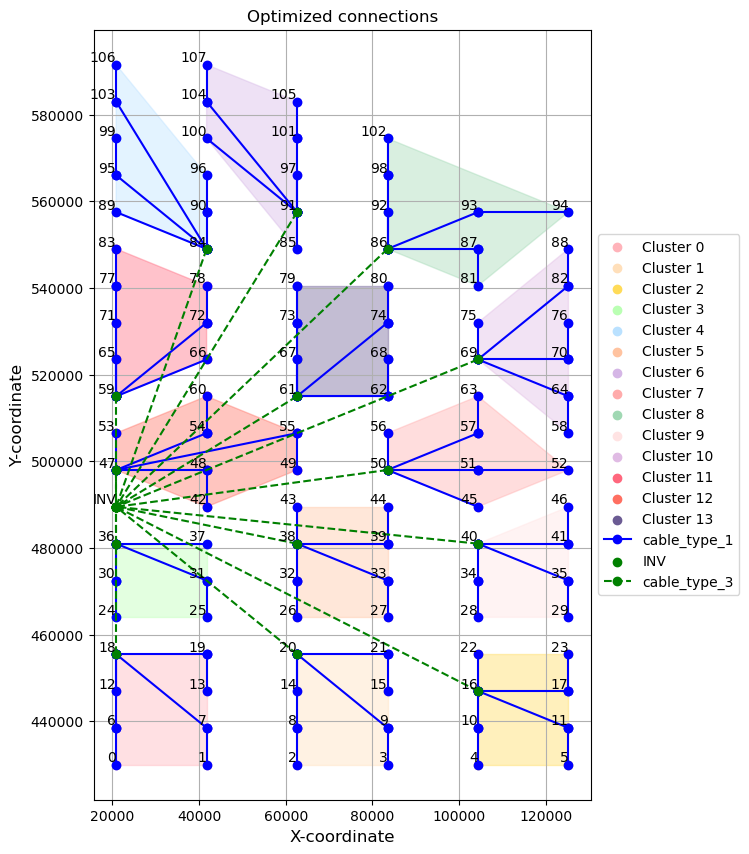

In [54]:
print('obj_sum=' ,obj_sum * 0.0039365)
plt.figure(figsize=(10, 10))
plot_clustering_with_custom_colors(c_data, clusters, centroids)
for k in connections_dic:
    cable_colors = {1: 'blue', 2: 'red'}
    for start, end, cable_type in connections_dic[k]:
        plt.plot([start[0], end[0]], [start[1], end[1]], color=cable_colors[cable_type], marker='o', label=f'cable_type_{cable_type}')

inverter = np.array([20870 , 489500 ])
#inverter = np.array([data[47, 1]-(data[100, 1]-data[99, 1]), data[47, 2]])
plt.scatter(x=inverter[0], y=inverter[1], color='green', label = 'INV')
plt.text(x=inverter[0], y=inverter[1],  ha='right', va='bottom', s='INV')
for i in range(len(data)):
    plt.text(x=data[i][1], y=data[i][2], ha='right', va='bottom', s = i)

for i, box in box_dic.items():
    plt.plot([box[0], inverter[0]], [box[1], inverter[1]], color='green', marker='o', 
             label=f'cable_type_{3}', linestyle='--')

plt.title('Optimized connections')
plt.xlabel('X-coordinate', fontsize=12)
plt.ylabel('Y-coordinate', fontsize=12)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()    